# Analysis on the job ads
In this notebook I am analysing the stored job ads, with the goal of gathering interesting insights.

In [5]:
import json
import spacy
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from fastai.text import TextList

In [6]:
# Read JSON file
with open('data/job_ads_container.json') as data_file:
    job_ads_container = json.load(data_file)

In [7]:
len(job_ads_container)

75

## Vectorising content with sk-learn

In [8]:
description_text = [job_ads_container[item]['Description'] for item in job_ads_container]

vectorizer = TfidfVectorizer(input='content', stop_words='english')
dtm = vectorizer.fit_transform(description_text).toarray()
vocab = np.array(vectorizer.get_feature_names())
dtm.shape, len(vocab)

((75, 2498), 2498)

In [9]:
vocab[645]

'descriptionthis'

In [10]:
dtm

array([[0.      , 0.      , 0.      , 0.      , ..., 0.      , 0.      , 0.      , 0.      ],
       [0.      , 0.      , 0.      , 0.      , ..., 0.      , 0.      , 0.      , 0.      ],
       [0.      , 0.      , 0.      , 0.      , ..., 0.      , 0.      , 0.      , 0.      ],
       [0.099683, 0.      , 0.091275, 0.      , ..., 0.      , 0.      , 0.      , 0.095024],
       ...,
       [0.107772, 0.      , 0.098682, 0.      , ..., 0.      , 0.079603, 0.      , 0.102735],
       [0.108754, 0.      , 0.      , 0.113977, ..., 0.      , 0.      , 0.      , 0.      ],
       [0.131013, 0.      , 0.      , 0.      , ..., 0.      , 0.      , 0.      , 0.      ],
       [0.13144 , 0.      , 0.      , 0.      , ..., 0.      , 0.      , 0.      , 0.      ]])

In [11]:
sum(dtm)

array([3.412238, 0.245548, 0.698898, 0.332998, ..., 0.421679, 0.999501, 0.136761, 0.627911])

In [12]:
description_text[1]

" DESCRIPTION Are you looking to work at the leading edge of advanced Machine Learning and Artificial Intelligence in healthcare and research?As a member of of the AWS EMEA Public Sector Healthcare Data Science team, you'll partner with our customers and AWS technology and business teams to help transform research, health and social care using AI and Cloud technologies.Example focus areas include Genomics, Clinical Decision Support, Population health and health system productivity.You will be working with terabytes of text, images, and other types of data to solve real-world problems. You'll develop novel use cases, design and run projects, research new algorithms, and find new ways of helping to improve clinical outcomes, productivity  and research using cloud.The primary responsibilities of this role are to:· Work with sales, business development and solution architecture teams to design and develop innovative solutions to healthcare customer needs· Use deep learning, machine learnin

In [13]:
scores = {'Words': vocab,'Scores':sum(dtm)}
word_scores = pd.DataFrame(data = scores)
word_scores.sort_values(by = ['Scores'],inplace = True, ascending = False)

In [14]:
word_scores

,Words,Scores
593,data,12.996997
1265,learning,4.928570
2013,science,4.733513
1329,machine,4.491789
847,experience,4.332866
...,...,...
1207,issuing,0.036185
1196,investigate,0.036185
499,condition,0.036185
168,analyticsbe,0.036185


## WordCloud

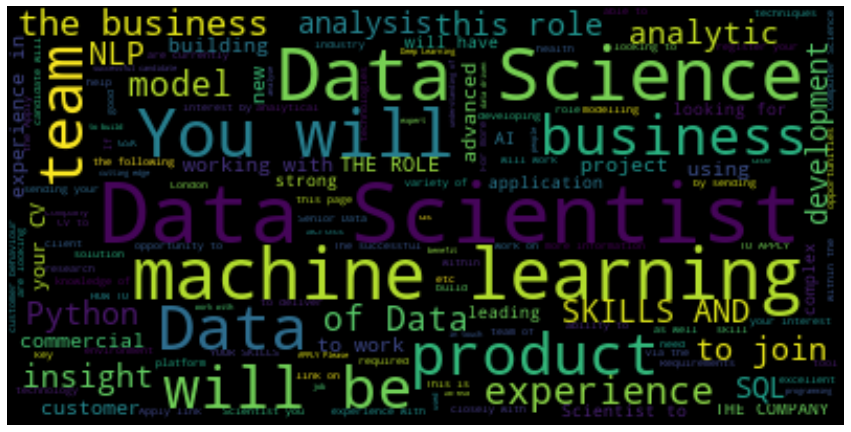

In [15]:
from wordcloud import WordCloud

text = ''
for desc in description_text:
    text+=desc

# Generate a word cloud image
wordcloud = WordCloud().generate(text)

# Display the generated image:
# the matplotlib way:


# lower max_font_size
wordcloud = WordCloud(max_font_size=40).generate(text)
plt.figure(figsize=(15, 15))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.savefig('data/wordcloud.png')
plt.show()